# Training Data Quality Assessment and Yellowking Error Analysis

**Why do we need to look at training data quality??**

The training data of our dataset was collected via targeted social media crowdsourcing campaigns, using the Mozilla common voice platform. Since the data is crowdsourced, there is always scope for mislabeled data and low recording quality, even after our prelim quality checks. 

**Through this notebook we are releasing** 

1. Data quality assessment scores (using NISQAv2) on the training set 
https://www.kaggle.com/datasets/imtiazprio/bengaliai-speech-train-nisqa
computed using https://github.com/gabrielmittag/NISQA
2. Common Voice filename mappings for the training set
https://www.kaggle.com/datasets/imtiazprio/bengaliai-speech-train-metadata
3. Yellowking and Google Speech API predictions on the training set
https://www.kaggle.com/datasets/imtiazprio/bengaliai-speech-train-metadata


**We look at**

1. Overall speech quality distribution in the training set.
2. We look at (listen to) the failure modes of Yellowking with high and low quality.
3. We look for contributor specific patterns in the training data. 

**We find:**

1. We see that there are good number of samples with very low quality, samples that can be excluded from training newer models. 
2. We can see that the marginal along people who have contributed to our dataset is quite long tailed.
3. We find that most that even the highest or lowest quality contributors have actually provided data of mixed quality.
4. We see that Yellowking is quite robust and many of its failure cases are due to label noise

**MAIN TAKEAWAY**

Use the quality metrics to subsample the training data and choose which samples to use for fine-tuning. Also given that yellowking is quite robust, the key challenge for the test dataset is the out-of-distribution effect.

## Quality Metrics:

**MOS**: Mean Opinion Score

**NOI**: Noiseness

**COL**: Coloration

**DIS**: Discontinuity

**LOUD**: Loudness

In [1]:
import pandas as pd
import soundfile as sf
from pydub import AudioSegment
import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/bengaliai-speech/train.csv",sep=",")
df.head()

,id,sentence,split
0,000005f3362c,ও বলেছে আপনার ঠিকানা!,train
1,00001dddd002,কোন মহান রাষ্ট্রের নাগরিক হতে চাও?,train
2,00001e0bc131,"আমি তোমার কষ্টটা বুঝছি, কিন্তু এটা সঠিক পথ না।",train
3,000024b3d810,নাচ শেষ হওয়ার পর সকলে শরীর ধুয়ে একসঙ্গে ভোজন...,train
4,000028220ab3,"হুমম, ওহ হেই, দেখো।",train


In [3]:
df_qa = pd.read_csv("/kaggle/input/bengaliai-speech-train-nisqa/NISQA_wavfiles.csv",sep=",")
df_qa.rename(columns={'deg':'id'},inplace=True) ## rename to match other dfs
df_qa['id'] = df_qa['id'].apply(lambda x:x.split('.')[0])  ## remove .wav
df_qa.sort_values('mos_pred',ascending=True,inplace=True) ## sort by mean overall score
df_qa.head()

,id,mos_pred,noi_pred,dis_pred,col_pred,loud_pred,model
132759,cebe4a39953b,0.243288,0.811499,1.750693,1.199304,1.136683,NISQAv2
622921,92b43a24c13c,0.265597,1.082415,2.310322,1.017868,1.035043,NISQAv2
472058,e818cefce6a5,0.286949,2.767413,1.064697,1.267965,0.879257,NISQAv2
407110,846be8ede4bb,0.302533,1.388240,1.677654,1.048659,1.000981,NISQAv2
102386,4d7232a0b2df,0.307023,2.820000,2.260859,1.575436,1.719826,NISQAv2


In [4]:
## Listen to lowest overall quality samples

path = "/kaggle/input/bengaliai-speech/train_mp3s/"
file = "4d7232a0b2df" 

## 4d7232a0b2df sounds like some sampling rate issue post recording
## cebe4a39953b is music playing in the background
## e818cefce6a5 is empty but somehow bypassed our algorithmic checks (!)
# possibly due to a divide by zero error

print(file)
display(AudioSegment.from_file(path+file+'.mp3'))
df[df['id']==file].sentence.tolist()[0] 

4d7232a0b2df


'দাঁত না মাজলে এমনই হবে, মেয়ে।'

<Axes: >

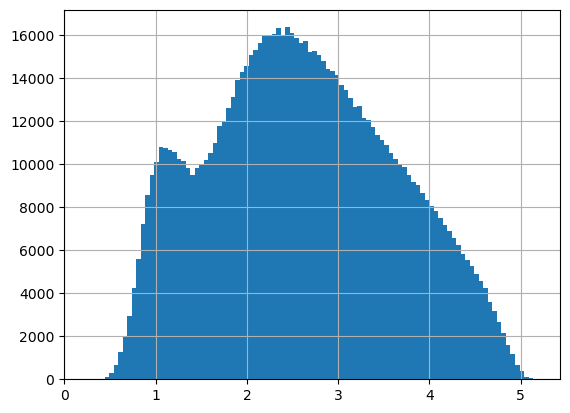

In [5]:
df_qa['mos_pred'].hist(bins=100)

In [6]:
## lets threshold at the notch in the histogram

df_qa[df_qa.mos_pred>1.5].sort_values('mos_pred',ascending=True).head()

,id,mos_pred,noi_pred,dis_pred,col_pred,loud_pred,model
807240,d30d2d8238ca,1.500005,2.931258,1.946900,2.407679,2.840325,NISQAv2
606692,95cd5f835ac8,1.500014,2.836581,2.264101,2.253320,2.436420,NISQAv2
801598,d178459bf62e,1.500018,2.352439,3.250199,1.838037,2.381220,NISQAv2
60499,477501e122ba,1.500022,1.912012,3.537630,2.507029,2.122332,NISQAv2
226288,04af7dea41d3,1.500025,2.399436,1.649416,2.781491,3.500767,NISQAv2


In [7]:
## lets listen to samples with MOS around 1.5

path = "/kaggle/input/bengaliai-speech/train_mp3s/"
file = "04af7dea41d3"

## d30d2d8238ca ground truth matches but some recording issue is still prevelant
## 04af7dea41d3 ground truth correct again but recording quality is low. This is a challenging example.

print(file)
display(AudioSegment.from_file(path+file+'.mp3'))
df[df['id']==file].sentence.tolist()[0]

04af7dea41d3


'আপনি ভাবছেন, আর ভাবছেন?'

In [8]:
df_meta = pd.read_csv("/kaggle/input/bengaliai-speech-train-metadata/train_metadata.csv",sep=",")
df_meta.set_index('id',inplace=True)

In [9]:
## join quality with meta, this will keep only training samples
df_meta = df_meta.join(df_qa.set_index('id'))

## keep only training samples for which we have QA calculated
df_meta.dropna(subset='mos_pred',inplace=True)

In [10]:
## count missing entries

for each in tqdm.tqdm(df_meta.columns):
    print(each, df_meta.filename.count() - df_meta[each].dropna().count())
    
    ## uncomment to plot trends for each metric
#     if not type(df_meta[each][0]) == str:
#         plt.figure()
#         plt.plot(df_meta[each][::10000].values)
#         plt.title(each)
    
    
## some samples do not have google predictions and yellowking predictions

  5%|▍         | 1/22 [00:00<00:06,  3.15it/s]

filename 0


 14%|█▎        | 3/22 [00:00<00:04,  4.43it/s]

client_id 0
ggl_cer 0


 23%|██▎       | 5/22 [00:00<00:02,  6.28it/s]

ggl_mer 0
ggl_wer 0


 32%|███▏      | 7/22 [00:01<00:02,  7.37it/s]

ggl_wil 0
ggl_wip 0


 36%|███▋      | 8/22 [00:01<00:02,  5.05it/s]

google_preds 77026


 41%|████      | 9/22 [00:01<00:03,  4.17it/s]

path 0


 45%|████▌     | 10/22 [00:02<00:03,  3.66it/s]

sentence 0


 55%|█████▍    | 12/22 [00:02<00:02,  4.17it/s]

yellowking_preds 701
ykg_mer 0


 64%|██████▎   | 14/22 [00:02<00:01,  5.65it/s]

ykg_wer 0
ykg_wil 0


 73%|███████▎  | 16/22 [00:03<00:00,  6.85it/s]

ykg_wip 0
ykg_cer 0


 82%|████████▏ | 18/22 [00:03<00:00,  7.66it/s]

mos_pred 0
noi_pred 0


 91%|█████████ | 20/22 [00:03<00:00,  8.09it/s]

dis_pred 0
col_pred 0


 95%|█████████▌| 21/22 [00:03<00:00,  8.21it/s]

loud_pred 0


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]

model 0


In [11]:
## how many unique sentences in ground truth. Maybe you can only keep one of each duplicate? 

df_meta.filename.count() - len(df_meta.sentence.unique())

419262

In [12]:
## lets look at which data contributors (clients) have provided the lowest quality data

unique_ids = df_meta.client_id.unique() 
print('Unique people in train', len(unique_ids))

Unique people in train 22009


In [13]:
## make an amenable client_id list
df_meta['client_idx'] = df_meta.client_id.map(dict(zip(unique_ids,range(len(unique_ids)))))

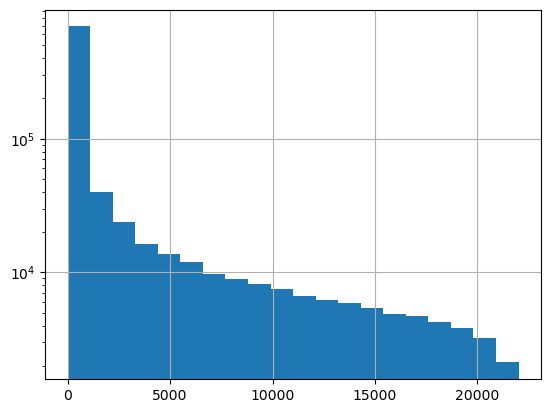

In [14]:
df_meta['client_idx'].hist(bins=20)
plt.yscale('log')

## contributor distribution quite long tailed
## why are client ids increasing with decreasing frequency? 
## is that something mozilla does on their platform?

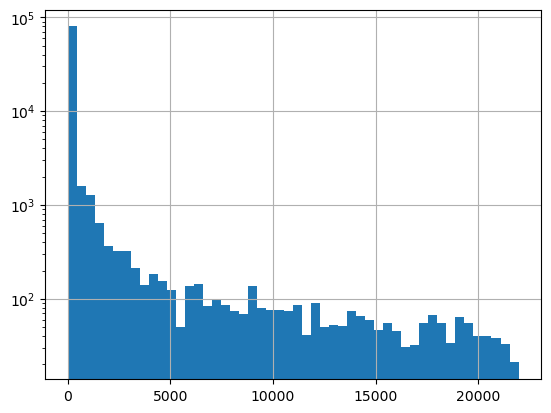

In [15]:
## sort by mos_pred, take the lowest 1/10 quality recordings and look at client distribution

subset = df_meta.sort_values('mos_pred').iloc[:df_meta.filename.count()//10]
subset.client_idx.hist(bins=50)
plt.yscale('log')

## some clients have a large number of low quality samples. 

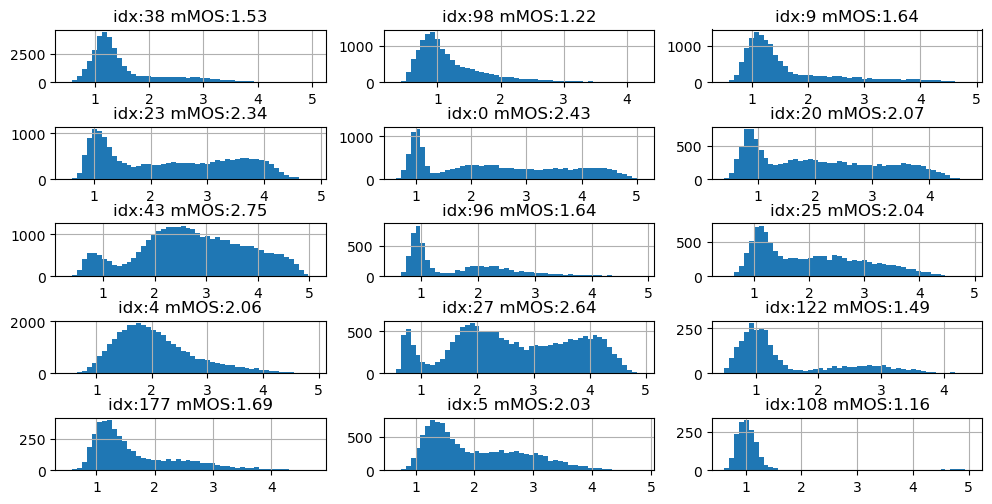

In [16]:
## find 15 worst quality contributors in the lowest quality samples
## check their quality distributions over all contributed samples

fig,axes = plt.subplots(5,3,figsize=(10,5))
fig.tight_layout()
axes = axes.reshape(-1)

for ax,each_client in zip(axes,subset.client_idx.value_counts().index[:15]): 
    df_meta[df_meta.client_idx == each_client].mos_pred.hist(bins=50,ax=ax)
    mean_mos = df_meta[df_meta.client_idx == each_client].mos_pred.mean()
    ax.set_title(f'idx:{each_client} mMOS:{mean_mos:.2f}')
#     plt.title(each_client)
    
## quality looks long-tailed/multi-modal, for some users majority mode is bad quality

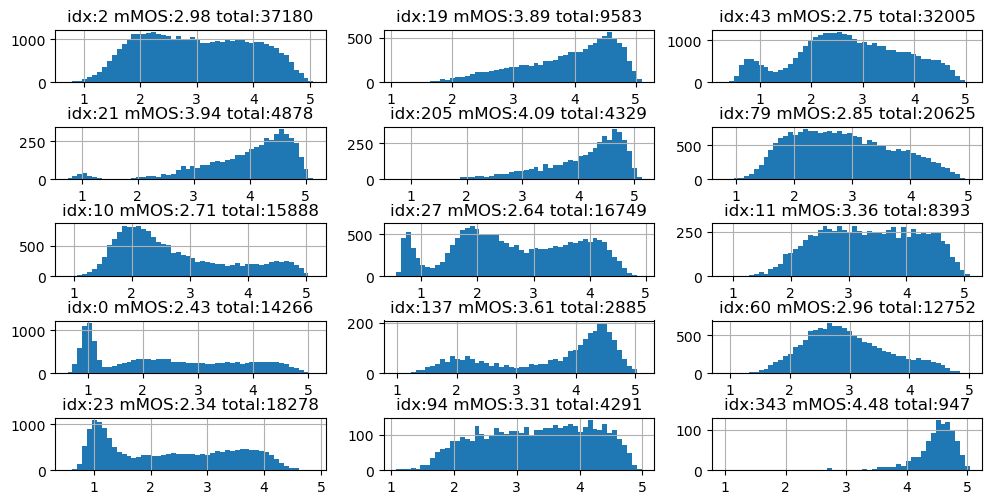

In [17]:
## sort by mos_pred, take the highest 1/10 quality recordings

subset = df_meta.sort_values('mos_pred',ascending=False).iloc[:df_meta.filename.count()//10]

## find 15 highest quality contributors in the high quality samples
## check their quality distributions over all contributed samples

fig,axes = plt.subplots(5,3,figsize=(10,5))
fig.tight_layout()
axes = axes.reshape(-1)

for ax,each_client in zip(axes,subset.client_idx.value_counts().index[:15]): 
    df_meta[df_meta.client_idx == each_client].mos_pred.hist(bins=50,ax=ax)
    total = df_meta[df_meta.client_idx == each_client].mos_pred.count()
    mean_mos = df_meta[df_meta.client_idx == each_client].mos_pred.mean()
    ax.set_title(f'idx:{each_client} mMOS:{mean_mos:.2f} total:{total}')
#     plt.title(each_client)
    
## looks like even for contributors with large number of high quality samples, not all
## contributed samples are high quality

In [18]:
## lets assume high quality contributors are good contributors
## lets listen to their lowest quality recordings to see what is up

client = subset.client_idx.value_counts().index[9]
print('Client_idx', client)

files = df_meta[df_meta.client_idx == client].sort_values('mos_pred').index.values

## Listen to lowest overall quality samples

path = "/kaggle/input/bengaliai-speech/train_mp3s/"

for file in files[:10]:
    display(AudioSegment.from_file(path+file+'.mp3'))
    print(df[df['id']==file].sentence.tolist()[0],f'mos:{df_meta.loc[file].mos_pred:.2f}')
    
    
## Client_idx 43 -> sounds like a recording/sampling rate issue
## Client_idx 2 -> random reading
## Client_idx 0 -> ground truth matches but recording issue

Client_idx 0


চিন্তার কী আছে? mos:0.63


সেটা কী জিনিস? mos:0.65


কী রে ভাই? mos:0.66


দেখেছ, কী সুন্দর! mos:0.66


একে কারম সাগরও বলা হয়। mos:0.67


কেইডেন্সের সাথে করতে যাচ্ছি। mos:0.67


না, অসম্ভব। mos:0.67


আমাদের কি এই কিউট গিরগিটিগুলো পালা উচিত না? mos:0.67


সে দেখতে কেমন? mos:0.68


এটা হুমায়ূনের সমাধি। mos:0.68


Text(0, 0.5, 'MOS')

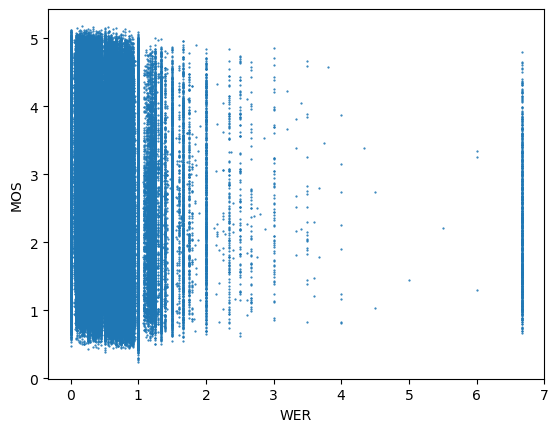

In [19]:
## Verdict: Subsampling data using data quality could be an interesting way to reduce the 
## volume of training data.


## Is Error Rate and MOS correlated? -> no, for both yellowking and google 

plt.scatter(df_meta.ykg_wer.values,df_meta.mos_pred.values,s=.3)
plt.xlabel('WER')
plt.ylabel('MOS')

In [20]:
## Lets listen to a recording correctly predicted by ykg that has low MOS

subset = df_meta[df_meta.ykg_wer < 1e-5]
files = subset.sort_values('mos_pred').index.values

path = "/kaggle/input/bengaliai-speech/train_mp3s/"

for file in files[:5]:
    display(AudioSegment.from_file(path+file+'.mp3'))
    print(f'MOS:{df_meta.loc[file].mos_pred:.2f}')
    print('Ground Truth',df[df['id']==file].sentence.tolist()[0])
    print('Ykg pred',df_meta.loc[file].yellowking_preds)
    print('Ggl pred',df_meta.loc[file].google_preds)
    
## DAMN!! Yellowking is insane!!

MOS:0.48
Ground Truth তারপর ফটকের দিকে ছুটে গেলেন।
Ykg pred তারপর ফটকের দিকে ছুটে গেলেন।
Ggl pred nan


MOS:0.54
Ground Truth তিনি আহত হন ও পরে মারা যান।
Ykg pred তিনি আহত হন ও পরে মারা যান।
Ggl pred কে আপন পর


MOS:0.56
Ground Truth কিছুই মনে করবে না।
Ykg pred কিছুই মনে করবে না।
Ggl pred nan


MOS:0.58
Ground Truth সারা জীবন ও এই কাজই করে চলেছে।
Ykg pred সারা জীবন ও এই কাজই করে চলেছে।
Ggl pred nan


MOS:0.59
Ground Truth তাতে কোনো সন্দেহ নেই।
Ykg pred তাতে কোনো সন্দেহ নেই।
Ggl pred nan


In [21]:
## Lets listen to a recording wrongly predicted by ykg that has high MOS

subset = df_meta.dropna(subset='yellowking_preds')[df_meta.ykg_wer > 3]
files = subset.sort_values('mos_pred').index.values

path = "/kaggle/input/bengaliai-speech/train_mp3s/"

for file in files[-10:]:
    display(AudioSegment.from_file(path+file+'.mp3'))
    print(f'MOS:{df_meta.loc[file].mos_pred:.2f}')
    print('Ground Truth',df[df['id']==file].sentence.tolist()[0])
    print('Ykg pred',df_meta.loc[file].yellowking_preds)
    print('Ggl pred',df_meta.loc[file].google_preds)
    
## Most of the samples have label noise! 
## Did people read wrong or does it have something to do with the common voice platform? 

/tmp/ipykernel_21/921392663.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df_meta.dropna(subset='yellowking_preds')[df_meta.ykg_wer > 3]


MOS:3.66
Ground Truth তার পিতা জার্মানিতে জন্মগ্রহণ করেন।
Ykg pred বাইরে গিয়ে কাব্য মামার হাতে এক কাপ মধুর চা আর সাথে হবে নদের সাথে পাট দা।
Ggl pred বাইরে গিয়ে খাবো মামার হাতে এককাপ মধুর চাক হাসাতে হবে বন্ধুদের সাথে আড্ডা


MOS:3.82
Ground Truth বেশি ভেবো না।
Ykg pred তিনি দু গ্রাম পি বেশি ব্যবহার বেশি ব্যবহার এবং যায় আসে।
Ggl pred বেশি ভালো না বেশি ভালো


MOS:3.84
Ground Truth বার্নার্ডো, না!
Ykg pred এই প্রতিগ্রাম নিয়ে বাড়ি না ও বানাতেন।
Ggl pred বাংলা নাটক


MOS:3.88
Ground Truth তিনি শিষ্য।
Ykg pred ভালো আছি ভালো থেকো আকাশের ঠিকানায় চিঠি লেখ।
Ggl pred ভালো আছি ভালো থেকো আকাশের ঠিকানায় চিঠি লিখো


MOS:3.88
Ground Truth হ্যা, ওকে।
Ykg pred তুলে একে ওকে হা ওকে হার কে।
Ggl pred ওকে ওকে


MOS:4.05
Ground Truth তার স্থলাভিষিক্ত হন রজার নাইট।
Ykg pred এবং প্রায় আমরা তার আদর্শ মিন্নচলার চেষ্টা করে কিন্তু দুঃখিত আমরা ফিতনার যুগে তা পালন করতে পারতেসি না।
Ggl pred এবং তাই আমরা তাঁর আদর্শ মেনে চলার চেষ্টা করি কিন্তু দুঃখিত আমরা ফিতনার যুগে তা পালন করতে পারতেছিনা


MOS:4.23
Ground Truth রেলপথটি ঢাকা-নারায়ণগঞ্জ-ঢাকা-মুন্সীগঞ্জ-শরীয়তপুর-মাদারীপুর-গোপালগঞ্জ-মাদারীপুর-বরিশাল-ঝালকাঠী-বরিশাল-পটুয়াখালী-বরগুনা-পটুয়াখালী এভাবে অতিক্রম করবে।
Ykg pred রেলটি ঢাকা নারয়ণগঞ্জ ঢাকা মঞ্চ গঞ্জ শরিতপুর মাদারীপুর গোপালগঞ্জ মাদারীপুর বরিশাল ঝালকাঠি বরিশাল পটুয়াখালী বরগুনা পটুয়াখালী এভাবে অতিক্রম করবে।
Ggl pred l&t ঢাকা-নারায়ণগঞ্জ-ঢাকা মুন্সিগঞ্জ shariatpur-madaripur গোপালগঞ্জ মাদারীপুর বরিশাল ঝালকাঠি বরিশাল পটুয়াখালী বরগুনা পটুয়াখালী এভাবে অতিক্রম করবে


MOS:4.58
Ground Truth এরপর রাস্তাটি উত্তরদিকে চলতে থাকে।
Ykg pred এবং আমি যখন কাপুর দুই তখন টুকি অমর কাজে ছিল সে বসবাস সদকি আমি জানতাম না এটাই শেষ দেখা।
Ggl pred এবং আমি যখন কাপড় জয়ী তখনও টোকিও আমার কাছে ছিল সে বসে বসে সব দেখছিল আমি জানতাম না এটাই তার শেষ দেখা


MOS:4.59
Ground Truth আরে, নোরাহ।
Ykg pred পুজো করে যোগ রাম আর নুর আরিনা।
Ggl pred আলিনুর


MOS:4.66
Ground Truth প্রফেসর, ভাই।
Ykg pred এ তো পরম প্রবেশের পর প্রবেশের পান।
Ggl pred ঋতুপর্ণার বই


In [22]:
## Lets listen to recordings wrongly predicted by ykg that has low MOS

subset = df_meta.dropna(subset='yellowking_preds')[df_meta.ykg_wer > 3]
files = subset.sort_values('mos_pred').index.values

path = "/kaggle/input/bengaliai-speech/train_mp3s/"

for file in files[:10]:
    display(AudioSegment.from_file(path+file+'.mp3'))
    print(f'MOS:{df_meta.loc[file].mos_pred:.2f}')
    print('Ground Truth',df[df['id']==file].sentence.tolist()[0])
    print('Ykg pred',df_meta.loc[file].yellowking_preds)
    print('Ggl pred',df_meta.loc[file].google_preds)
    
## Most of the samples have label noise! AGAIN!
## Yellowking seems to be quite trustable as a pre-trained model to begin with

/tmp/ipykernel_21/827945281.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df_meta.dropna(subset='yellowking_preds')[df_meta.ykg_wer > 3]


MOS:0.82
Ground Truth তোমার কী হয়েছে!
Ykg pred কিন্তু লাভ পেয়ে এক্স বড় অংশ পানির ব্যক্তি শিরবানশিনাল ভিম্বর আর কাবিলা।
Ggl pred nan


MOS:0.83
Ground Truth না, এটা মথ।
Ykg pred অত্র আসিতে দেওয়া আছে না পাসারি খেলা মানে বিষয়ক আরাজি সহসা পরিবারে।
Ggl pred nan


MOS:0.83
Ground Truth চলো, বন্ধুরা।
Ykg pred পরে এটা ভাত জলন্ধর বার্গার থেকে যা।
Ggl pred nan


MOS:1.04
Ground Truth আরে, না!
Ykg pred খাইয়া অজসুলতানে আসে আমি তার কি মটনের সমস্ত নয়।
Ggl pred nan


MOS:1.17
Ground Truth মা, বাবা!
Ykg pred দুইটি গাল খান নেতা যাতে মাটি তুলে না।
Ggl pred বেবি গার্ল ফ্রেন্ড


MOS:1.21
Ground Truth এটিই তার একমাত্র সেঞ্চুরি ছিল।
Ykg pred রানি ইংরেজ মেন্ট পরে দলে প্রবেশ নিজ বা ল্যাম্বলজার্জ দুটোর কোনটাই আপনাকে মেনে হবে না শুধু পন্ডিত এক্সপেনসিভ।
Ggl pred nan


MOS:1.24
Ground Truth সে কানা নাকি?
Ykg pred জীবনে একবার খাইম্বাল ইজি বাড়ি বা কেউ পরনে লাভ করি সে পিনকন জাতীয়তাবাদিরা।
Ggl pred ইমন একবার খাইলাম কেউ পারবেনা


MOS:1.31
Ground Truth অবশ্যই ভালো বেতন।
Ykg pred অস্কার সেন সিনিয়ার মে অনেক সময় অর্থিতানহা সে আবার জনাবিশেক সিনিয়ার হয়েছে জুনিয়রদের বেশি পাকা বরলিয়া বিস্কে কুকারে।
Ggl pred nan


MOS:1.39
Ground Truth হ্যাঁ, জানি।
Ykg pred পোড়া শাহ জানিয়ে আমি জানি জানি দেন।
Ggl pred জানি আমি জানি জানি জানি


MOS:1.45
Ground Truth হ্যাঁ, অসাধারণ।
Ykg pred বিক্রির হার ছিলেন না যোগ ভাষা করে।
Ggl pred হাউস
